In [ ]:
#| hide
from hybridpredictmaize22.GEMdataset import *

In [ ]:
#| hide
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from pathlib import Path

# hybridpredictmaize22

> GxExM yield prediction

Repo for analysis of GEM prediction for maize yield

## Install

```sh
pip install hybridpredictmaize22
```

## How to use

A demo of the library specifically for this dataset

Generate random data that is the same form as the actual dataset

In [ ]:
import random
#generate random SNP matrix
gene_dosages = [0, .5, 1]
years = [2018,2019]
snp_length = 100
number_hybrids = 20


number_environments = 10
env_col = []
for i,y in zip(np.arange(number_environments),[random.choice(years) for _ in range(number_environments)]):
    env_col.append(f'{i}_{y}')

snp_matrix = (np.arange(number_hybrids),np.array([[random.choice(gene_dosages) for x in range(snp_length)] for _ in range(number_hybrids)]))

#generate random yield data
random_yields = [random.uniform(-1,1) for _ in range(100)]
random_hybrids = [random.choice(range(number_hybrids)) for _ in range(100)]
random_environments = [random.choice((env_col)) for _ in range(100)]

In [ ]:
yield_data = pd.DataFrame({"Hybrid":random_hybrids, "Yield_Mg_ha":random_yields, 'Env':random_environments})
yield_data.head()

,Hybrid,Yield_Mg_ha,Env
0,0,0.172954,0_2018
1,9,0.700284,4_2018
2,7,-0.799937,8_2019
3,12,-0.892540,5_2019
4,12,0.681444,5_2019


In [ ]:
Weather_Table = np.random.random((50,number_environments))
weather_table = {}
for c,i in enumerate(Weather_Table):
    weather_table[c] = i
    
weather_data = pd.DataFrame(weather_table)
weather_data.insert(0,'Env',env_col)
weather_data.insert(1,'Year',[x.split('_')[1] for x in env_col])

weather_data

,Env,Year,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,0_2018,2018,0.339318,0.645351,0.596769,0.674014,0.839884,0.806496,0.999808,0.736149,...,0.056324,0.348315,0.885774,0.213902,0.956378,0.620997,0.085156,0.375406,0.372505,0.259006
1,1_2018,2018,0.572323,0.125541,0.686176,0.277879,0.768659,0.013587,0.925902,0.559293,...,0.715583,0.181945,0.528709,0.144964,0.367816,0.740463,0.270510,0.310422,0.131063,0.194258
2,2_2019,2019,0.889345,0.452250,0.763568,0.818604,0.096647,0.317412,0.069779,0.357168,...,0.412320,0.129185,0.766032,0.863806,0.620753,0.285642,0.554314,0.204787,0.453862,0.888054
3,3_2019,2019,0.492631,0.262753,0.527975,0.654456,0.220014,0.900263,0.287942,0.989492,...,0.241567,0.654816,0.778694,0.857906,0.896364,0.703187,0.115679,0.495839,0.191042,0.603319
4,4_2018,2018,0.368332,0.300210,0.363662,0.289667,0.735534,0.974251,0.734114,0.137067,...,0.454452,0.261224,0.455968,0.658335,0.119698,0.204962,0.244722,0.851620,0.391992,0.923202
5,5_2019,2019,0.534571,0.192684,0.409649,0.898634,0.045608,0.642902,0.495185,0.812611,...,0.116396,0.101575,0.863596,0.099896,0.472187,0.909758,0.373246,0.021258,0.141784,0.794518
6,6_2018,2018,0.569923,0.474057,0.312642,0.612845,0.510297,0.534694,0.422548,0.476793,...,0.943216,0.358081,0.961395,0.100413,0.233050,0.008584,0.646845,0.763853,0.356459,0.764686
7,7_2018,2018,0.207798,0.710351,0.510869,0.239727,0.271019,0.207443,0.325767,0.021929,...,0.122032,0.259493,0.498929,0.049220,0.621886,0.040410,0.475822,0.130571,0.306685,0.410237
8,8_2019,2019,0.915032,0.620752,0.103160,0.211781,0.904108,0.688374,0.175970,0.508636,...,0.864712,0.410570,0.792315,0.869885,0.598791,0.822897,0.901996,0.085463,0.678950,0.675902
9,9_2018,2018,0.732095,0.241041,0.366285,0.400097,0.641570,0.473785,0.028948,0.676443,...,0.280371,0.080082,0.348361,0.458913,0.965020,0.715099,0.170961,0.975335,0.836953,0.707490


In [ ]:
yield_data

,Hybrid,Yield_Mg_ha,Env
0,0,0.172954,0_2018
1,9,0.700284,4_2018
2,7,-0.799937,8_2019
3,12,-0.892540,5_2019
4,12,0.681444,5_2019
...,...,...,...
95,14,0.403292,6_2018
96,15,-0.584356,9_2018
97,5,-0.442337,0_2018
98,5,0.582230,1_2018


In [ ]:
#Create a GEM dataset
test_split = 2019
gem = GEM(test_split)
gem.Y = YT(yield_data, test_split)
gem.W = WT(weather_data, test_split)
gem.SNP = snp_matrix

In [ ]:
#example of how to unscale a value
gem.Y.scaler.inverse_transform(np.array(1.4).reshape(-1,1))

array([[0.72497222]])

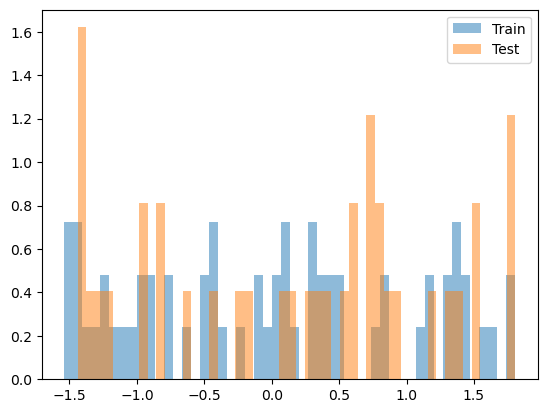

In [ ]:
gem.Y.plot_yields()

In [ ]:
ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
next(iter(ds))

(0.4306352768532538,
 array([0. , 1. , 0. , 0. , 0. , 0. , 0. , 1. , 0.5, 1. , 0. , 0. , 0. ,
        0. , 1. , 1. , 1. , 0. , 1. , 0.5]),
 array([[-0.71524192,  1.07874277,  0.91088512,  1.5270517 ,  1.11322279,
          0.93109807,  1.23907291,  1.13221733, -0.16217186, -0.94644327,
         -1.29547698,  1.18767089, -0.28106303, -1.62111753, -1.25439181,
          0.74721689, -0.40219838, -0.94991248,  0.11836801,  1.45003639,
          0.2085608 ,  1.26145177, -0.22833088,  1.33564082, -0.66387703,
         -1.69727085,  1.23139475, -1.58403587, -0.14933558, -0.17806999,
          0.37216138, -0.1451076 ,  1.00816768,  0.69339373, -0.52115649,
          1.33239693,  1.09584004,  1.92880839, -0.03361344, -0.13238862,
         -1.17509009,  1.04532305,  1.19806318, -0.26282049,  1.24236785,
          0.74561763, -1.21357394, -0.61928798, -0.12512069, -1.04847961]]))